In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
sys.path.append('py_scripts')
import cloud_lib as cl
import ppe_class_lib as ppe_lib

/home/users/eers/sct/py_scripts/ppe_class_lib.py:107: SyntaxWarning: invalid escape sequence '\D'
  self.parameter_labels = ['$BL~q_{v}$', '$BL~z$', r'$\Delta~\theta$', '$\Delta~q_{v}$', '$BL~N_{a}$', '10^{$b_{aut}$}']


In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def calculate_parameter_values(member, member_index, time_index, dictionary):
    dt_subcloud_top, dt_blz_ind, dictionary["delta_theta"][member_index] = cl.get_deltheta_thresh(member.ds, time_index)
    dictionary["delta_qv"][member_index] = (member.ds.vapour_mmr_mean[time_index,dt_blz_ind+20]*1e3 - member.ds.vapour_mmr_mean[time_index,dt_subcloud_top]*1e3).values
    dictionary["bl_z"][member_index] = member.ds.zn[dt_blz_ind]
    dictionary["bl_qv"][member_index] = member.ds.vapour_mmr_mean[time_index,5:dt_subcloud_top].mean()*1e3
    dictionary["n_a"][member_index] = member.ds.q_accum_sol_number_2d_time_z[time_index,5:dt_subcloud_top].mean().values*1e-6 # whole BL: dt_blz_ind OR just subcloud layer: dt_subcloud_top
    return dictionary

In [4]:
ppe = ppe_lib.Ensemble(include_spinup=True, delete_bad=False)

Initiating ensemble...
Loading members
Ensemble initialised.


### Post spinup (after 1 hour)

In [11]:
ppe_set = ppe.member_keys  # calculate for all PPE members
post_spin = {"delta_theta": np.empty((len(ppe_set))),
             "delta_qv": np.empty((len(ppe_set))),
             "bl_z": np.empty((len(ppe_set))),
             "bl_qv": np.empty((len(ppe_set))),
             "n_a": np.empty((len(ppe_set))),
             "baut": np.empty((len(ppe_set)))}
index = 1
for i, key in enumerate(ppe_set):
    member = vars(ppe)[key]
    post_spin = calculate_parameter_values(member, i, index, post_spin)


Text(0.5, 0.01, 'Latin hypercube design')

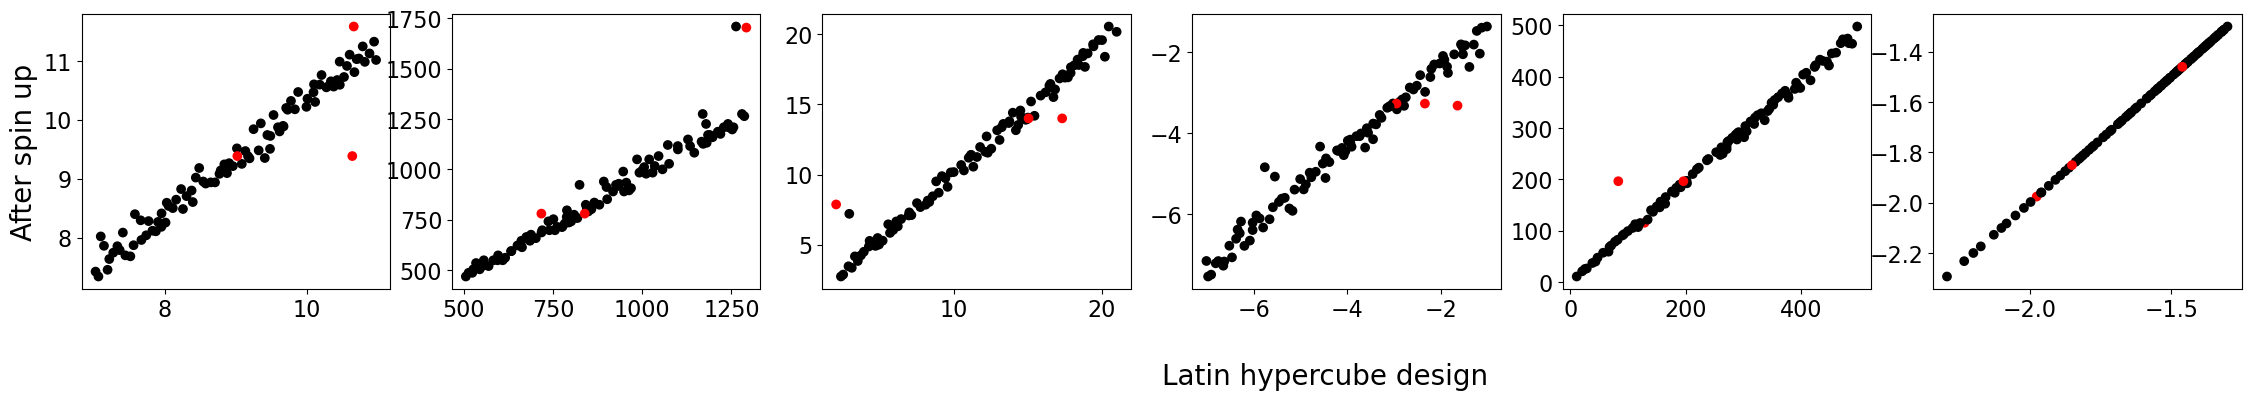

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(24,5))
plt.subplots_adjust(top=0.75, bottom=0.2, wspace=0.2, left=0.05, right=0.95)

# ppe.design = np.delete(ppe.design, (6,86,93), axis=0)
post_spin['baut'] = ppe.design[:,5]
colours = ['black']*len(ppe.design)
for i in [6,86,93]:
    colours[i] = 'red'

for j, (a, key) in enumerate(zip(ax, ["bl_qv","bl_z","delta_theta","delta_qv","n_a","baut"])):
    a.scatter(ppe.design[:,j], post_spin[key],c=colours)

ax[0].set_ylabel("After spin up")
fig.text(0.5,0.01,"Latin hypercube design", fontsize=MEDIUM_SIZE)

In [ ]:
fig.savefig("figures/compare_spinup_thresholdvals.png")
fig.savefig("figures/compare_spinup_thresholdvals.pdf")

In [10]:
post_cat = np.empty((len(ppe.design), 6))
for j, key in enumerate(["bl_qv","bl_z","delta_theta","delta_qv","n_a","baut"]):
    post_cat[:, j] = post_spin[key]
    
np.savetxt("lh_design/post_spinupvalues/all_post_spinup.csv", post_cat, delimiter=',', header="bl_qv,bl_z,delta_theta,delta_qv,n_a,baut",comments='')

### At the beginning of Sc time (None if no Sc formed)

In [20]:
ppe = ppe_lib.Ensemble(include_spinup=False, delete_bad=False)

Initiating ensemble...
Loading members
Ensemble initialised.


In [21]:
ppe_set = ppe.member_keys  # calculate for all PPE members
sc_beginning = {"delta_theta": np.empty((len(ppe_set))),
                 "delta_qv": np.empty((len(ppe_set))),
                 "bl_z": np.empty((len(ppe_set))),
                 "bl_qv": np.empty((len(ppe_set))),
                 "n_a": np.empty((len(ppe_set))),
                 "baut": np.empty((len(ppe_set)))}

for i, key in enumerate(ppe_set):
    member = vars(ppe)[key]

    if member.sc_ind is not None:
        sc_beginning = calculate_parameter_values(member, i, member.sc_ind, sc_beginning)
    else:
        sc_beginning["delta_theta"][i] = None
        sc_beginning["delta_qv"][i] = None
        sc_beginning["bl_z"][i] = None
        sc_beginning["bl_qv"][i] = None
        sc_beginning["n_a"][i] = None

Text(0.5, 0.01, 'Latin hypercube design')

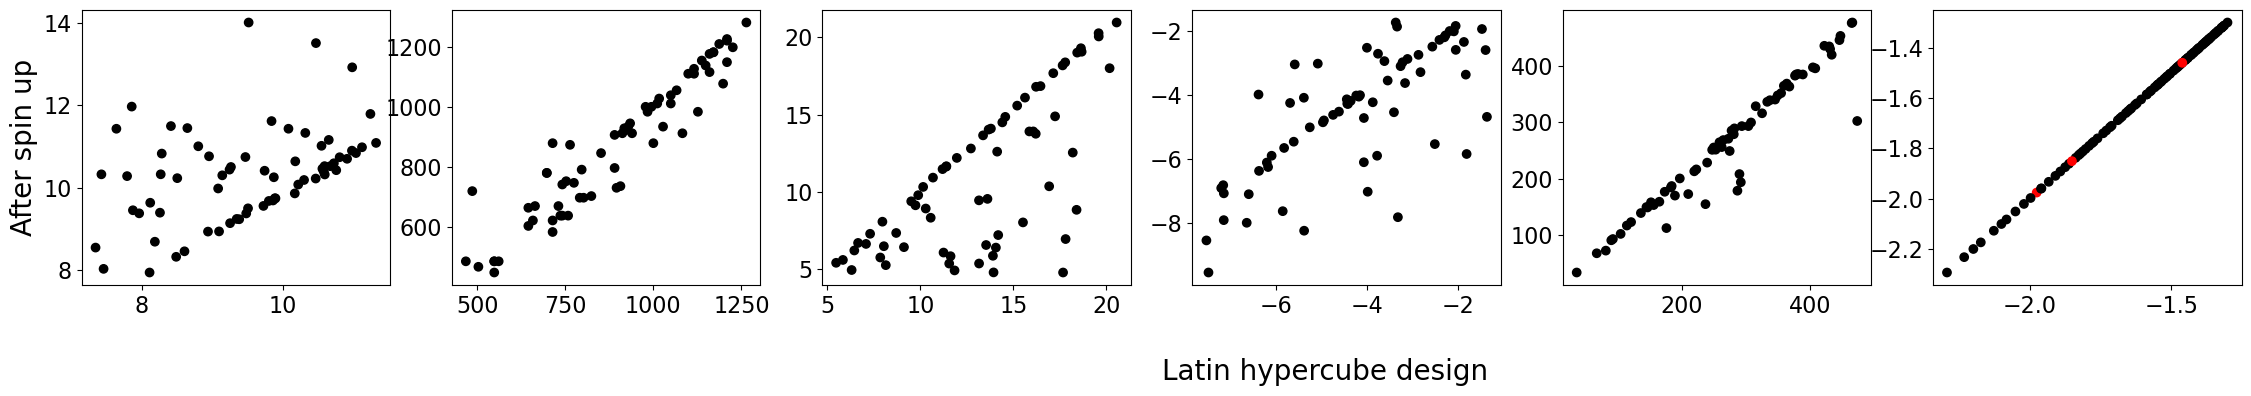

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(24,5))
plt.subplots_adjust(top=0.75, bottom=0.2, wspace=0.2, left=0.05, right=0.95)

# ppe.design = np.delete(ppe.design, (6,86,93), axis=0)
sc_beginning['baut'] = ppe.design[:,5]
colours = ['black']*len(ppe.design)
for i in [6,86,93]:
    colours[i] = 'red'

for j, (a, key) in enumerate(zip(ax, ["bl_qv","bl_z","delta_theta","delta_qv","n_a","baut"])):
    a.scatter(ppe.design[:,j], sc_beginning[key],c=colours)

ax[0].set_ylabel("After spin up")
fig.text(0.5,0.01,"Latin hypercube design", fontsize=MEDIUM_SIZE)

In [23]:
fig.savefig("figures/compare_sc_beginning_thresholdvals.png")
fig.savefig("figures/compare_sc_beginning_thresholdvals.pdf")

In [24]:
post_cat = np.empty((len(ppe.design), 6))
for j, key in enumerate(["bl_qv","bl_z","delta_theta","delta_qv","n_a","baut"]):
    post_cat[:, j] = sc_beginning[key]

np.savetxt("lh_design/post_spinupvalues/all_sc_beginning.csv", post_cat, delimiter=',', header="bl_qv,bl_z,delta_theta,delta_qv,n_a,baut",comments='')

### Plots showing the calculated subcloud top and transition top

In [4]:
heights=[]
qv_prof=[]
th_prof=[]
with open('master_ppe_input_csvs/string_master_array.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='|')
    line_count=0
    for row in csv_reader:
        if line_count!=0:
            heights.append([float(i) for i in row[1].split(',')])
            th_prof.append([float(i) for i in row[2].split(',')])
            qv_prof.append([float(i)*1e3 for i in row[3].split(',')][:len(heights[line_count-1])])
        line_count+=1

Text(0.5, 0.98, 'Potential temp initial profiles')

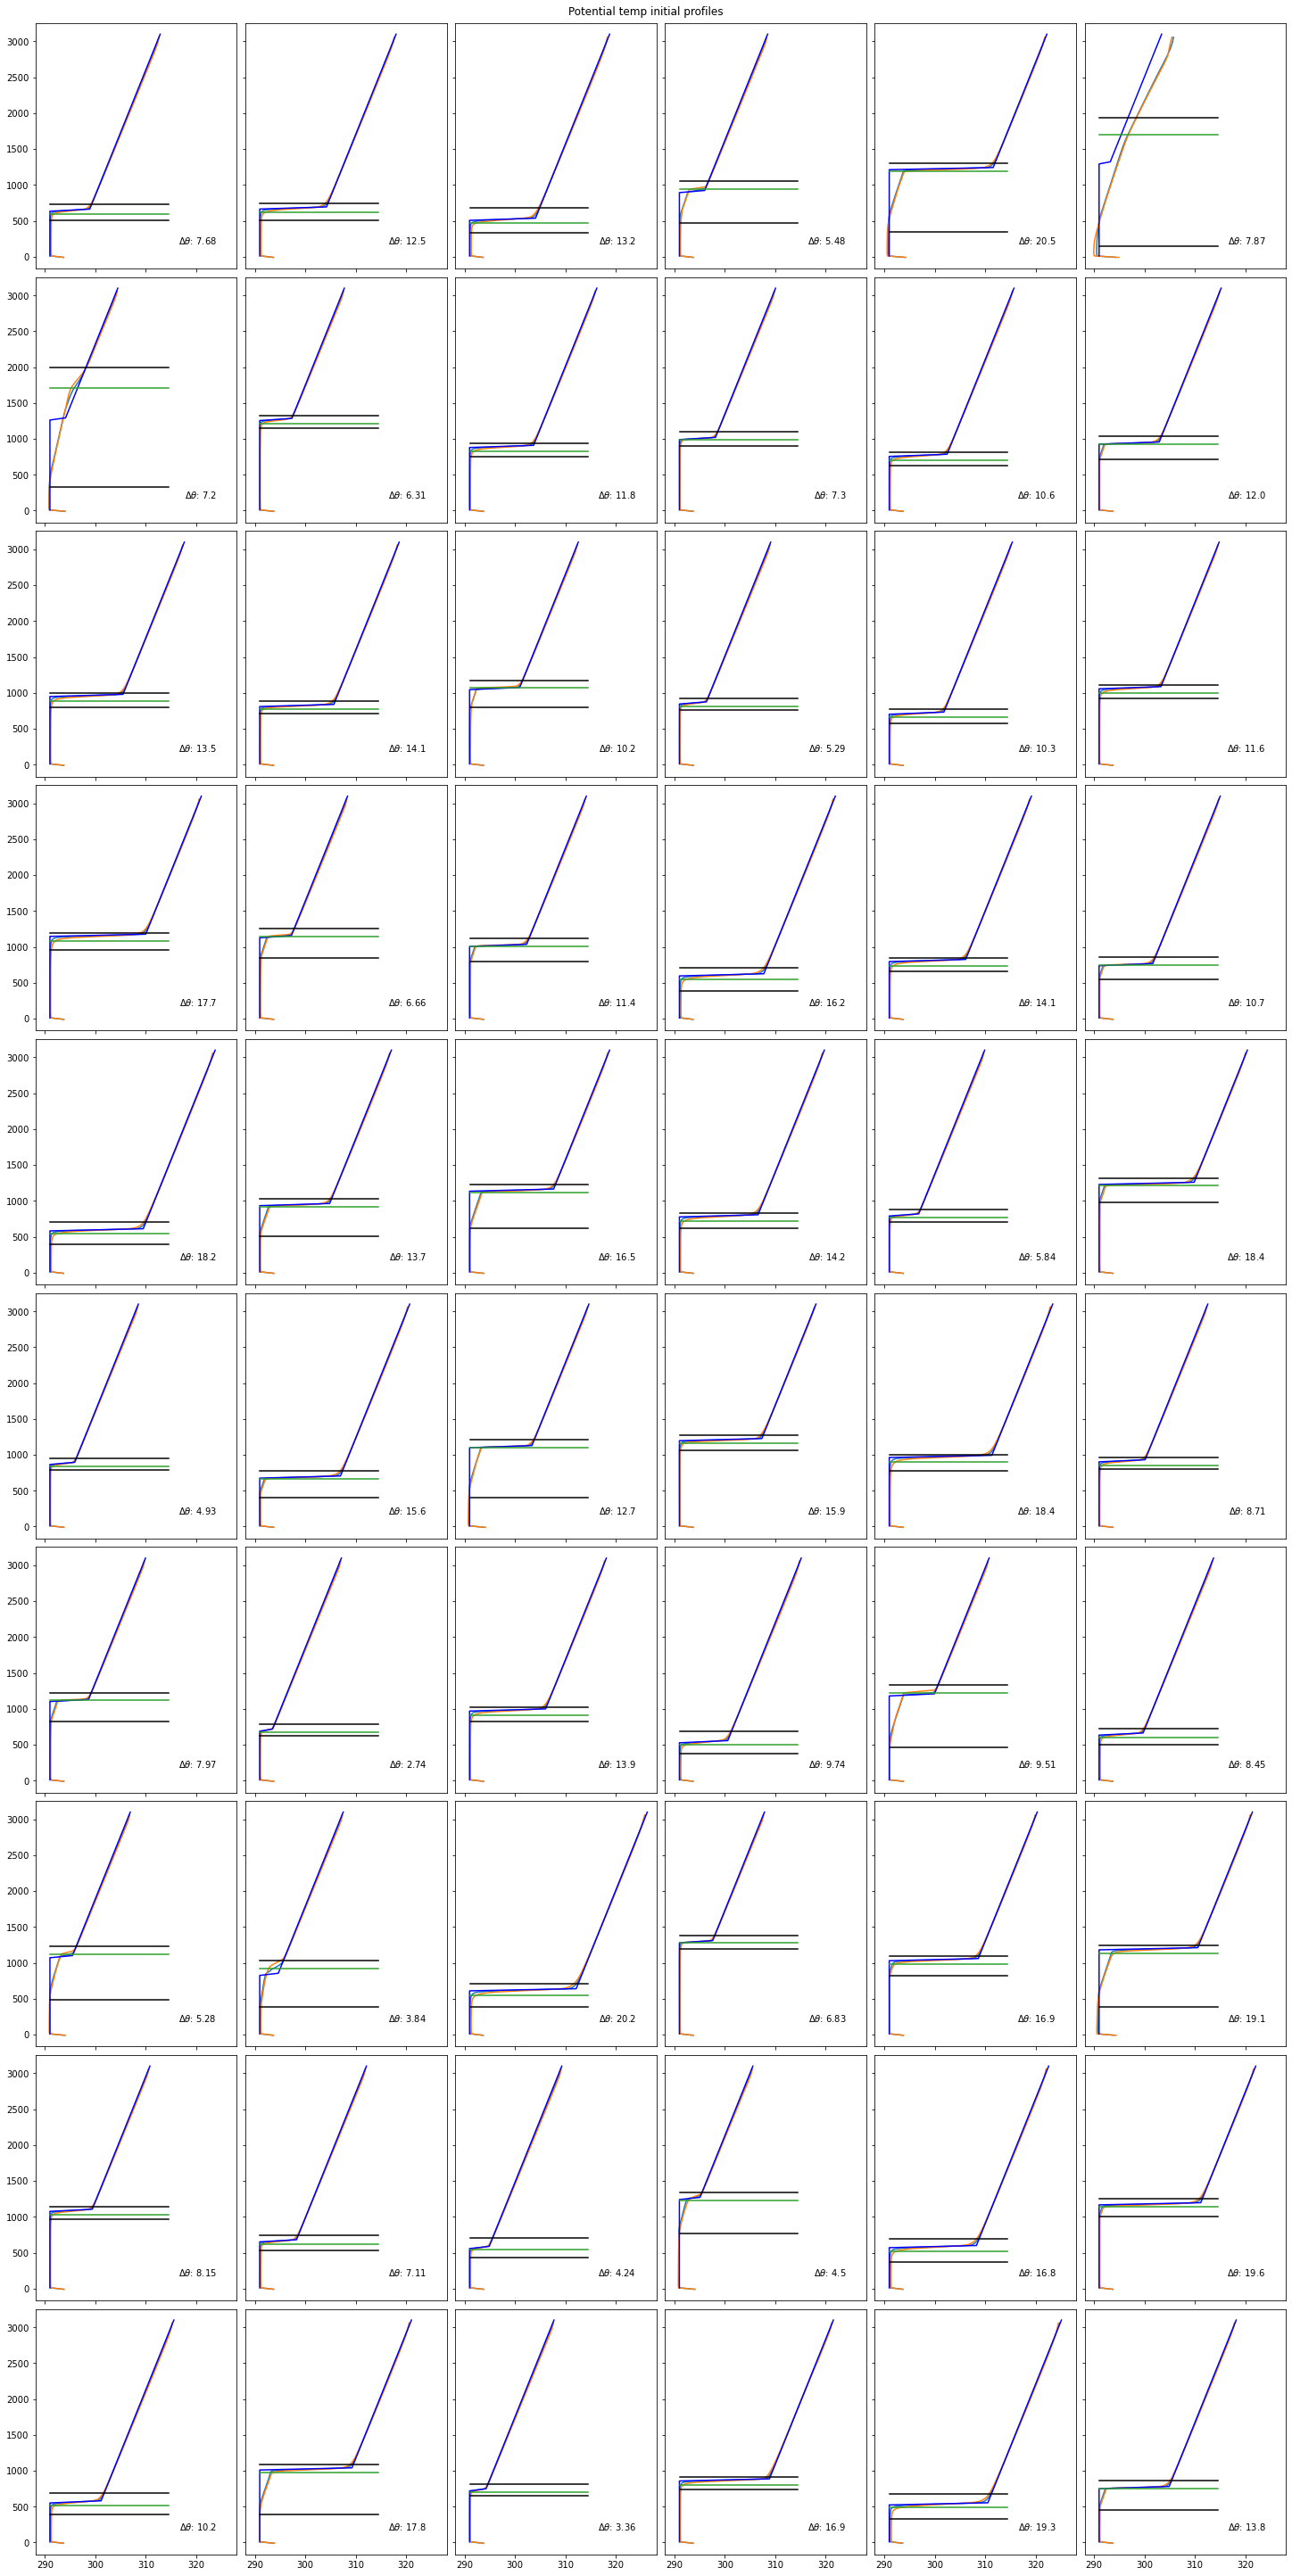

In [23]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)
        
ind = 0
sim_type = 'em'
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/{sim_type}/{sim_type}{b-1}/sct_{sim_type}{b-1}_merged.nc')
    
    ds.theta_mean[0].plot(y='zn', ax=a)
    ds.theta_mean[1].plot(y='zn', ax=a)
    a.plot(th_prof[b-1], heights[b-1], c='blue')

    subcloud_top, inv_ind, diff = cl.get_deltheta_thresh(ds, 1)
    a.plot((m1, m2), (ds.zn[inv_ind], ds.zn[inv_ind]))
    a.plot((m1, m2), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    l,=a.plot((m1, m2), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]), c='black', label=f'{diff:0.3}')
    
    #clbas_ave = np.mean(ds.clbas.where(ds['clbas']!=0.0), axis=(1,2))
    #cltop_ave = np.mean(ds.cltop.where(ds['cltop']!=0.0), axis=(1,2))
    #a.plot((m1, m2), (clbas_ave[1], clbas_ave[1]), c='red')
    #a.plot((m1, m2), (cltop_ave[1], cltop_ave[1]),c='red')
    a.set_title('')
    a.set_ylabel('')
    a.set_xlabel('')

    label = r'$\Delta \theta$'
    a.text(0.9, 0.1,f"{label}: {diff:0.3}", transform=a.transAxes,ha='right')
    
fig.text(0.5,0.01,"Potential temperature (K)", ha='center', va='center')
fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
#fig.savefig("pot_temp_profiles_inv_split_winitial.png")

Text(0.5, 0.98, 'Vapour mmr initial profiles')

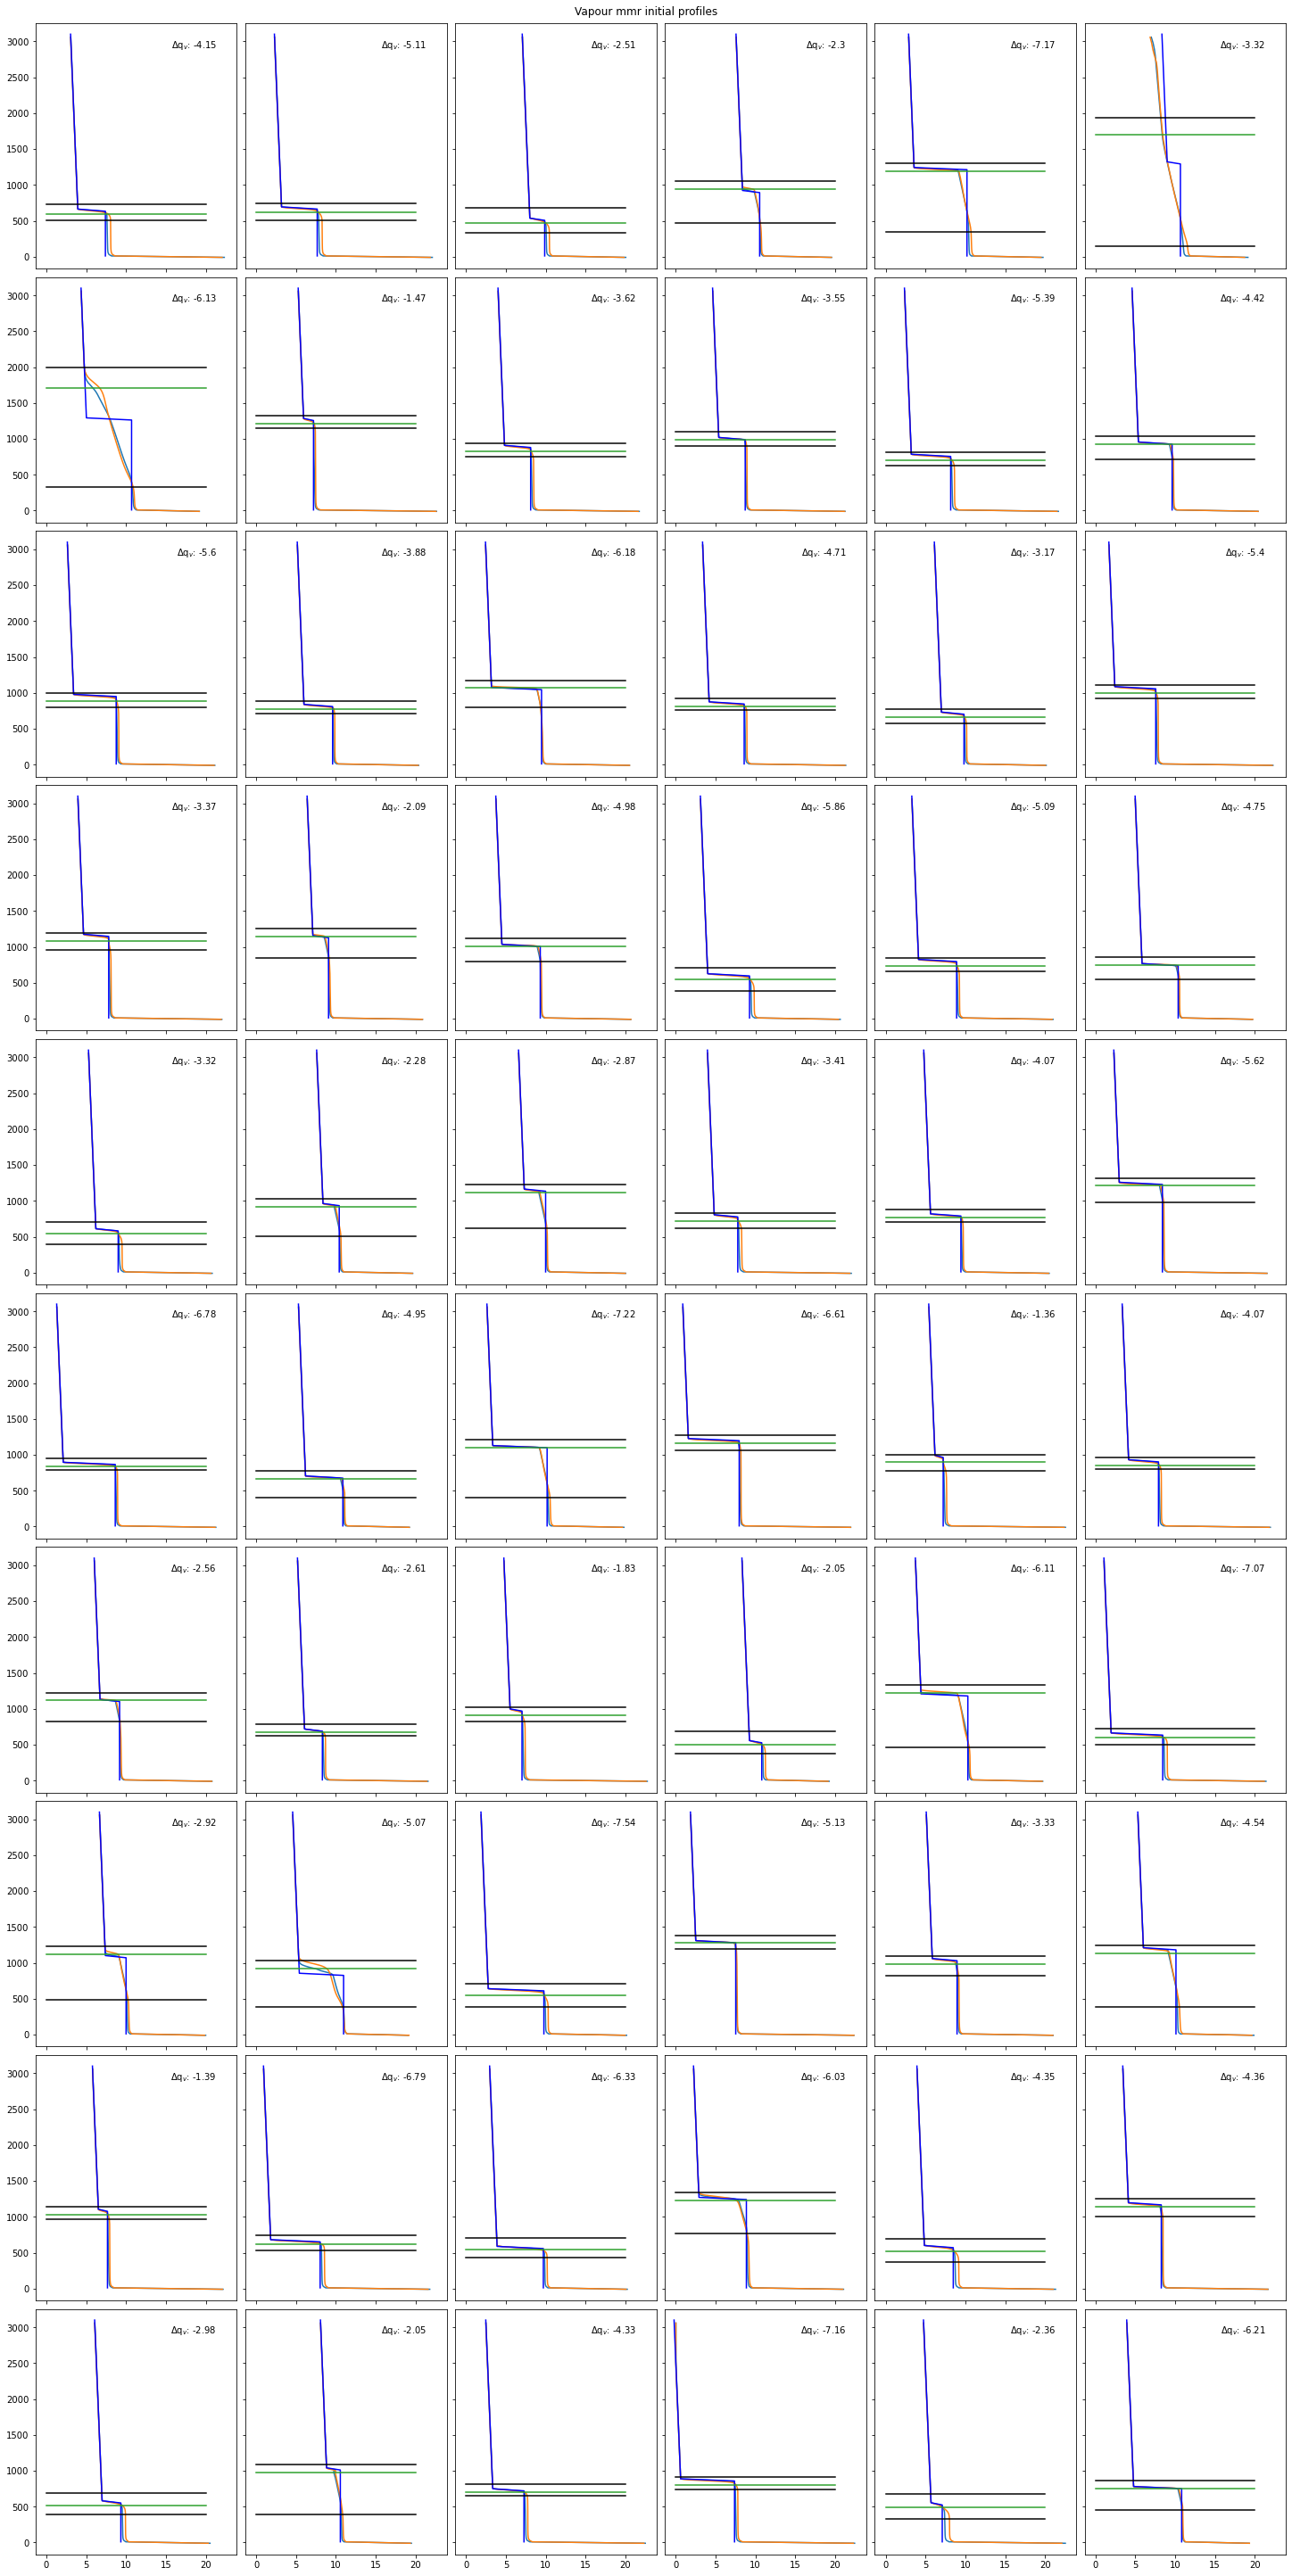

In [25]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)

ind = 0
sim_type = 'em'
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/{sim_type}/{sim_type}{b}/sct_{sim_type}{b}_merged.nc')

    zeroth=ds.vapour_mmr_mean[0]*1e3
    zeroth.plot(y='zn', ax=a)
    first=ds.vapour_mmr_mean[1]*1e3
    first.plot(y='zn', ax=a)
    a.plot(qv_prof[b-1], heights[b-1],c='blue')
    
    subcloud_top, inv_ind, diff = cl.get_deltheta_thresh(ds, 1)
    diff = (ds.vapour_mmr_mean[1,inv_ind+20]*1e3 - ds.vapour_mmr_mean[1,subcloud_top]*1e3).values
    a.plot((0,20), (ds.zn[inv_ind], ds.zn[inv_ind]))
    a.plot((0,20), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    a.plot((0,20), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]),c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')
    label = '$\Delta$q$_{v}$'
    a.text(0.9, 0.9,f"{label}: {diff:0.3}", transform=a.transAxes,ha='right')
    
#fig.text(0.5,0.01,"Vapour mmr (g/kg)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Vapour mmr initial profiles")
#fig.savefig("vap_mmr_profiles_inv_split_winitial.png")